In [1]:
import sklearn
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from tabulate import tabulate
from utils import *
import load_datasets

In [11]:
# X, y = load_datasets.dataset_to_X_y('diabetes.csv')
X, y = make_blobs(n_samples=10, centers=2, n_features=10, random_state=0)

In [14]:
N, dim = X.shape
d = dim + 1
Xones = (np.insert(X.T, 0, np.ones(N)).reshape(dim+1, N)).T
theta0 = np.zeros(dim + 1)

experiments = [
    compressedGD(gradf, theta0, Xones, y, name='Without'),
    compressedGD(gradf, theta0, Xones, y, compression=topK, k=d//3, name='Top-k, k=d/3'),
    compressedGD(gradf, theta0, Xones, y, compression=topK, k=1, name='Top-k, k=1'),
    compressedGD(gradf, theta0, Xones, y, compression=uniformCompression, name='Rand-k, k=d/2'),
    compressedGD(gradf, theta0, Xones, y, compression=uniformCompression, k=1, name=r'Rand-k, k=1'),
    stochasticCompressedGD(gradf, theta0, Xones, y, compression=stochasticCompression, name='Stochastic, k=d/2'),
]

experiments.sort(key=lambda exp : exp['k'] * exp['num_iter'])

table = [
    ["compression", "num_iter", "transmitted coordinates"],
    *[
        [exp['name'], exp['num_iter'], exp['k'] * exp['num_iter']]
        for exp in experiments
    ]
]
print(tabulate(table))

-----------------  --------  -----------------------
compression        num_iter  transmitted coordinates
Top-k, k=1         177       177
Rand-k, k=1        380       380
Rand-k, k=d/2      87        435
Top-k, k=d/3       177       531
Stochastic, k=d/2  323       1615
Without            156       1716
-----------------  --------  -----------------------


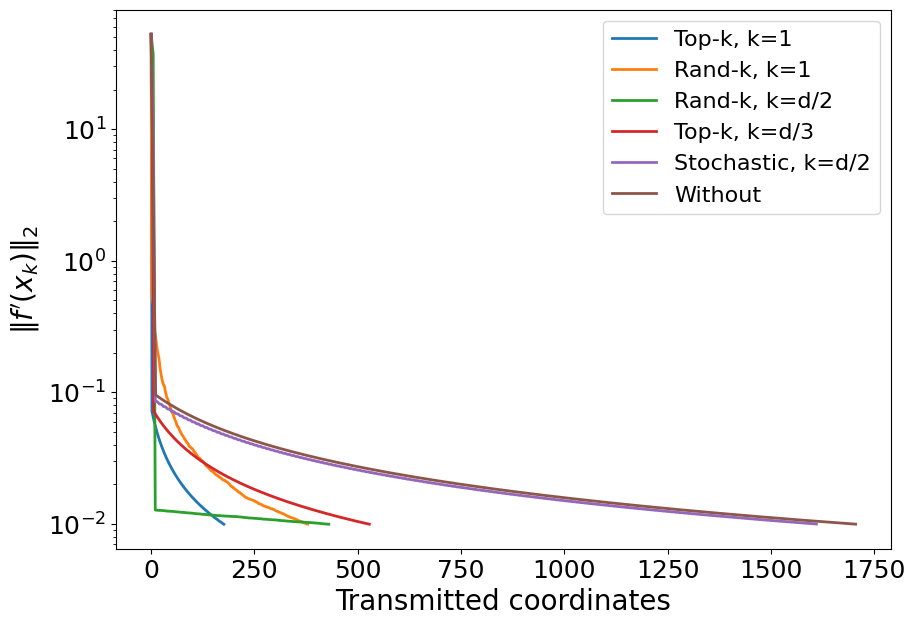

In [15]:
plt.figure(figsize=(10, 7))
for exp in experiments:
    plt.semilogy(
        exp['coords'],
        [grad_norm for grad_norm in exp['gradients']],
        label=exp['name'],
        linewidth=2
    )
plt.legend(loc="best", fontsize=16)
plt.xlabel(r"Transmitted coordinates", fontsize=20)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)